In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead).
| YrFireName                  | A unique identifier for each fire event that includes the year of the fire and the fire name                                    
| Times_burned                | The number of times this tree was burned                                            
| Species                     | Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number                                                   
| Genus_species               | Genus and species of tree                                       
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters)
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters)
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01).

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv', low_memory = False)

In [3]:
# explore data set
pd.set_option("display.max_columns", None)
trees_dat.head(5)

,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,Subspecies,Genus_species,DBH_cm,DRC_cm,HT_m,HCB_pre,CR_pre,CC,VR,CL_m,yr0status,yr1status,yr2status,yr3status,yr4status,yr5status,yr6status,yr7status,yr8status,yr9status,yr10status,HCB_post,CR_post,CSH_m,CLS_m,CLK_m,CLS_percent,CLK_percent,CVS_percent,CVK_percent,CVC_percent,CBS,BCHA_m,BCHM_m,BCH_percent,BCA,CKR,GCA,GIR_percent,DMR,BTL,AB,DFB,FEN,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
0,2006 - Tripod,2TREE,Prichard,1,NaN,188,15,NaN,NaN,NaN,NaN,Unknown,26.416,NaN,21.03,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,21.03,21.03,100.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
1,2006 - Tripod,2TREE,Prichard,1,NaN,74,20,NaN,NaN,NaN,NaN,Unknown,1.270,NaN,2.13,1.52,0.29,NaN,NaN,0.61,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,0.61,0.61,29.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
2,2006 - Tripod,2TREE,Prichard,1,NaN,193,22,NaN,NaN,NaN,NaN,Unknown,25.400,NaN,18.29,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,18.29,18.29,100.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
3,2006 - Tripod,2TREE,Prichard,1,NaN,126,6,NaN,NaN,NaN,NaN,Unknown,8.382,NaN,14.33,8.84,0.38,NaN,NaN,5.49,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,8.08,12.80,89.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN
4,2006 - Tripod,2TREE,Prichard,1,NaN,113,11,NaN,NaN,NaN,NaN,Unknown,21.844,NaN,11.89,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,11.89,11.89,100.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


In [4]:
# Select only relevant columns
trees_dat = trees_dat[['YrFireName', 'Times_burned', 'Species', 'Genus_species',  'DBH_cm', 'HT_m', 'CR_pre', 'CR_post', 'yr1status']]

In [5]:
trees_dat.dtypes

YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
yr1status        float64
dtype: object

In [6]:
# Remove all rows with NaNs
trees_dat = trees_dat.dropna()

In [7]:
trees_dat['YrFireName'].unique()

array(['2003 - Griff', '2002 - McNalley', '1999 - Bucks', '2001 - Star',
       '2000 - Storrie', '2001 - Swain', '1999 - Volcano Fall',
       '2000 - Volcano Spring', '2003 - B and B', '2006 - Shake Table',
       '2007 - Grapple', '2002 - Biscuit', '2002 - Apple',
       '2003 - Davis Lake', '2002 - Tiller', '1999 - Rancheria Creek',
       '2005 - School', '2006 - Tripod', '1983 - Upper Priest',
       '1984 - Lower Priest', '2006 - Sharps Ridge',
       '2003 - Bull Springs', '2006 - Columbia', '2002 - Tenderfoot Fall',
       '2005 - Blossom', '2007 - Monument', '2002 - Lubrecht',
       '2003 - Tenderfoot Spring', '2016 - Maple', '2002 - Cone',
       '1994 - Barkley', '1994 - Crystal', '2004 - Power',
       '2005 - Second Hud', '2007 - Egley', '2004 - Nile',
       '2004 - Squaw Creek', '2005 - Pearrygin Lake', '2006 - Sisters',
       '2004 - Fischer', '2001 - Quartz', '2004 - Black Rock',
       '1997 - Driveway 14 - Fall', '1998 - Driveway 14 - Spring',
       '1998 - Drive

In [8]:
# Print total number of observations
print(f"The number of rows within the new cleaned data set is: {trees_dat.shape[0]}")

The number of rows within the new cleaned data set is: 36509


In [9]:
# Look at cleaned data frame
trees_dat.head()

,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,yr1status
500,2003 - Griff,1,ABAM,Abies_amabilis,71.374,41.76,0.84,0.74,0.0
501,2003 - Griff,1,ABAM,Abies_amabilis,23.622,12.80,0.60,0.57,0.0
502,2003 - Griff,1,ABAM,Abies_amabilis,46.228,34.75,0.75,0.59,0.0
503,2003 - Griff,1,ABAM,Abies_amabilis,21.082,23.16,0.38,0.38,0.0
504,2003 - Griff,1,ABAM,Abies_amabilis,24.384,26.21,0.42,0.42,0.0


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [10]:
# Recode categorical predictors to integers
for col in ['YrFireName', 'Species', 'Genus_species']: # Factorize all categorical variables
    trees_dat[col],_ = pd.factorize(trees_dat[col], sort=True) 
    
# Check process worked...
trees_dat.head()

,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,yr1status
500,37,1,0,0,71.374,41.76,0.84,0.74,0.0
501,37,1,0,0,23.622,12.80,0.60,0.57,0.0
502,37,1,0,0,46.228,34.75,0.75,0.59,0.0
503,37,1,0,0,21.082,23.16,0.38,0.38,0.0
504,37,1,0,0,24.384,26.21,0.42,0.42,0.0


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [11]:
# Assign predictor and outcome variables 
X = trees_dat.loc[:, trees_dat.columns != 'yr1status']
Y = trees_dat['yr1status']

# Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [12]:
# Standardize the predictors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

3. How many training/test observations do we have? Print your answer in the cell below. 

In [13]:
# Verify the training and testing set size
print(f"Training set observations:{X_train.shape[0]}" )
print(f"Testing set observations:{y_test.shape[0]}")

Training set observations:25556
Testing set observations:10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [14]:
# Create a classifier using LogisticRegression()
model = LogisticRegression() 
model.fit(X_train, y_train) # Fit model

# Probablity of y over threshold
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)

In [15]:
print(f"Training Accuracy: {score}")

Training Accuracy: 0.9423902127271068


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

In [16]:
# Print evaluation metrics
print(f"Metrics: {classification_report(y_test, y_pred)}")

Metrics:               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     10049
         1.0       0.74      0.47      0.57       904

    accuracy                           0.94     10953
   macro avg       0.85      0.73      0.77     10953
weighted avg       0.94      0.94      0.94     10953



In [17]:
# Define confusion matrix
def plot_confusion_matrix(actual, predicted):
    
    # Create confusion matrix
    cm = confusion_matrix(actual, predicted)
    
    # Create confusion matrix plot
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, fmt = 'd', cmap = 'YlOrRd',annot = True,
    xticklabels = ['Dead', 'Alive'], # how to tell which cell is which
    yticklabels = ['Dead', 'Alive'])
    
    plt.title('Confusion Matrix of Dead or Alive Trees')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    
    # Calculate and display metrics
    TP = cm[0,0] 
    FP = cm[0,1] 
    FN = cm[1,0]
    TN = cm[1,1]
    
    print(f"True positives (correctly predicted presence): {TP}")
    
    
    # Calculate accuracy + various metric 
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP/ (TP + FN)
    specificity = TN / (TN + FP )
    
    
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity ( True positive rate): {sensitivity:.3f}")
    print(f"Specificity ( True negative rate:) {specificity:.3f}")

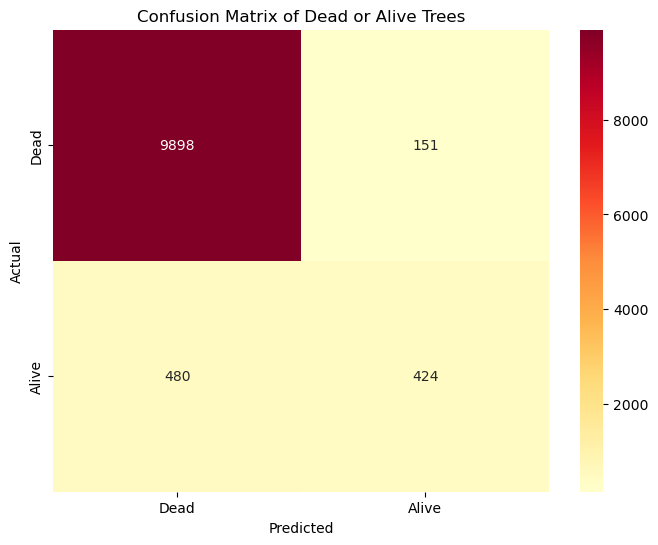

True positives (correctly predicted presence): 9898

Model Performance Metrics:
Accuracy: 0.942
Sensitivity ( True positive rate): 0.954
Specificity ( True negative rate:) 0.737


In [18]:
plot_confusion_matrix(y_test, y_pred)

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model's accuracy, or the number of trees correctly classified out of all the trees present in the test set, is 94.5%. This is very good. Looking at the model performance metrics further: the sensitivity rate of the model was 95.7% and the specificity rate of the model was 73.0%. This shows that the model predicts trees belonging to the positive or negative class (of all the trees in the positive or negative class in the test pool), at rates of 95.7 and 73.0 percent, respectively. This is also quite good, but does show a discrepancy in that the model tends to be better at predicting if trees are dead than if they had survived. There is a majority class imbalance in the data - as an overwhelming majority of the trees in the sample are shown to be dead.

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (dead trees)? How would its accuracy compare to your logistic regression model?

As the majority of the observations in the `yr1status` column are dead - I believe that building a model that always predicts the majority class would have a similiar accuracy to our previous model. However, there will a massively negative impact on the specificity rate - and a slight impact to the sensitivty rate as well.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

In [19]:
# Create and fit dummy model to always predict majority class
dummy_model = DummyClassifier(strategy = "most_frequent")
dummy_model.fit(X_train, y_train)

# Calculate dummy model accuracy
dummy_ypred = dummy_model.predict(X_test)
dummy_score = accuracy_score(y_test, dummy_ypred)

Dummy Accuracy: 0.9174655345567424


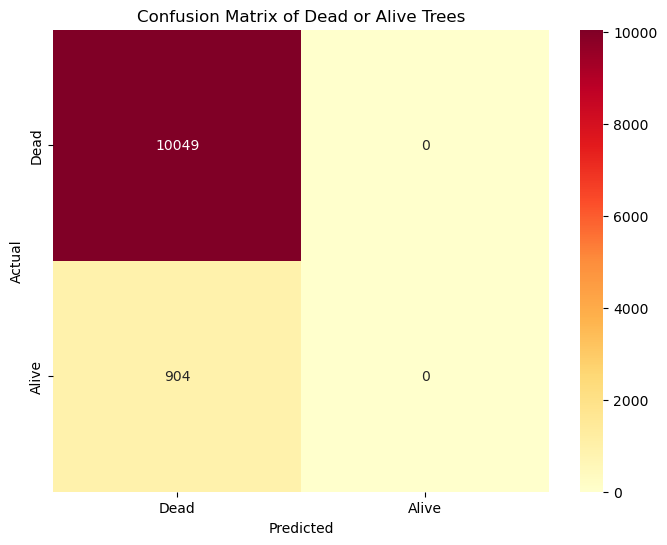

True positives (correctly predicted presence): 10049

Model Performance Metrics:
Accuracy: 0.917
Sensitivity ( True positive rate): 0.917
Specificity ( True negative rate:) nan
Dummy Confusion Matrix: None


/tmp/ipykernel_1463125/1635722932.py:31: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP )


In [20]:
# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {dummy_score}")
print(f"Dummy Confusion Matrix: {plot_confusion_matrix(y_test, dummy_ypred)}")

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [21]:
# Logistic classifier AUC
# Find y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

print(f"Logistic AUC: {roc_auc_score(y_test, y_pred_prob)}")

Logistic AUC: 0.9267959784665757


In [22]:
# Dummy classifier AUC
# Find y_pred_prob of dummy
dummy_ypred_prob = dummy_model.predict_proba(X_test)[:,1]

print(f"Dummy AUC: {roc_auc_score(y_test, dummy_ypred_prob)}")

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

In [23]:
# Set up curves
fpr, tpr, _ = roc_curve(y_test, y_pred_prob) # for Logisitic Regression

d_fpr, d_tpr, _ = roc_curve(y_test, dummy_ypred_prob) # For Dummy Majority Classifier

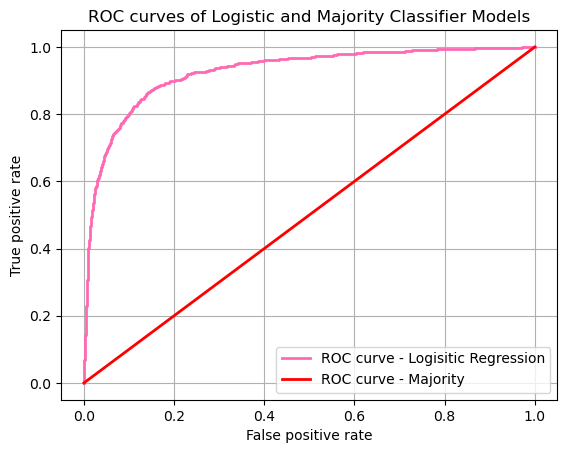

In [24]:
# Set up plot
plt.plot(fpr, tpr, color = 'hotpink', lw =2, label = 'ROC curve - Logisitic Regression')
plt.plot(d_fpr, d_tpr, color = 'red', lw =2, label = 'ROC curve - Majority')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves of Logistic and Majority Classifier Models')
plt.legend()
plt.grid(True)

plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The two models have differing AUCs as seen in Step 8 - where the Logisitic Regression Model and Majority Dummy Models had AUCs of 0.926 and 0.5, respectively. This implies that the Logistic Regression model has a higher probablity of assigning a randomly chosen tree as dead, than as alive. In the dummy model (majority classifier), the AUC of 0.5 assigns a random tree a higher probability of being dead than alive only half the time.

Thus the implications of this evaluation, would be that we would ultimately use the model that has a better prediction accuracy - which in this case would be the Logistic Regression model.

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [25]:
# Coefficients and Odds Ratios
coefficients = model.coef_[0]

# Display feature importance using coefficients and odds ratios
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
})

importance_df['Coefficient'] = pd.to_numeric(importance_df['Coefficient']).abs()

# Print the sorted feature importance
print(importance_df.sort_values(by='Coefficient', ascending= False))

         Feature  Coefficient
7        CR_post     2.395274
5           HT_m     1.126992
0     YrFireName     0.655371
2        Species     0.451795
4         DBH_cm     0.377314
6         CR_pre     0.134226
3  Genus_species     0.019848
1   Times_burned     0.000000


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The most important features in the model - according to the prior calculations - is a variable named `CR_post`. This was defined in the metadata as the "Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01)" [USDA](https://www.fs.usda.gov/rds/archive/products/RDS-2020-0001/_metadata_RDS-2020-0001.html) This conclusion can inform forest managment policy and conservatino strategy - as t can help to mitigate the spread and impact of forest fires. (Presumably managing the crowns/ drybrush - will decrease the rate at which the fire accelerates through an area. This can reduce the number of trees that die in the immediate aftermath of a forest/wildfire.)